# reactome_data 代码练习

In [1]:
import os
os.chdir('D:/github_project/BioXNet')
os.getcwd()

'D:\\github_project\\BioXNet'

In [2]:
import sys
sys.path.append('D:/github_project/BioXNet/data_loader')
sys.path.append('D:/github_project/BioXNet/data_loader/Reactome/')
sys.path

['d:\\github_project\\BioXNet\\coding_practice',
 'd:\\anaconda\\envs\\bioxnet\\python311.zip',
 'd:\\anaconda\\envs\\bioxnet\\DLLs',
 'd:\\anaconda\\envs\\bioxnet\\Lib',
 'd:\\anaconda\\envs\\bioxnet',
 '',
 'd:\\anaconda\\envs\\bioxnet\\Lib\\site-packages',
 'd:\\anaconda\\envs\\bioxnet\\Lib\\site-packages\\win32',
 'd:\\anaconda\\envs\\bioxnet\\Lib\\site-packages\\win32\\lib',
 'd:\\anaconda\\envs\\bioxnet\\Lib\\site-packages\\Pythonwin',
 'D:/github_project/BioXNet/data_loader',
 'D:/github_project/BioXNet/data_loader/Reactome/']

In [3]:
import re
import networkx as nx
import pandas as pd
from os.path import join
from gmt_reader import GMT
from pathlib import Path

## 导入数据

- ReactomePathways.txt 包含 reactome_id、pathway_name、species
- ReactomePathways.gmt 包含 pathway 及其有关的基因
- ReactomePathwaysRelation.txt 包含 pathway 之间的层次结构

In [4]:
data_dir = Path("data/").joinpath('reactome')
data_dir

WindowsPath('data/reactome')

In [5]:
pathway_names = pd.read_csv(join(data_dir, 'ReactomePathways.txt'), sep='\t')
pathway_names.columns = ['reactome_id', 'pathway_name', 'species']
pathway_names

,reactome_id,pathway_name,species
0,R-BTA-1971475,A tetrasaccharide linker sequence is required ...,Bos taurus
1,R-BTA-1369062,ABC transporters in lipid homeostasis,Bos taurus
2,R-BTA-382556,ABC-family proteins mediated transport,Bos taurus
3,R-BTA-9033807,ABO blood group biosynthesis,Bos taurus
4,R-BTA-418592,ADP signalling through P2Y purinoceptor 1,Bos taurus
...,...,...,...
21238,R-XTR-193639,p75NTR signals via NF-kB,Xenopus tropicalis
21239,R-XTR-111995,phospho-PLA2 pathway,Xenopus tropicalis
21240,R-XTR-191859,snRNP Assembly,Xenopus tropicalis
21241,R-XTR-379724,tRNA Aminoacylation,Xenopus tropicalis


In [6]:
gmt = GMT()
pathway_genes = gmt.load_data(join(data_dir, 'ReactomePathways.gmt'), pathway_col=1, genes_col=3)
pathway_genes # 一条通路对应多个基因

,group,gene
0,R-HSA-164843,HMGA1
1,R-HSA-164843,LIG4
2,R-HSA-164843,PSIP1
3,R-HSA-164843,XRCC4
4,R-HSA-164843,XRCC5
...,...,...
118300,R-HSA-192905,NP
118301,R-HSA-192905,NS
118302,R-HSA-192905,PA
118303,R-HSA-192905,PB1


In [7]:
# 非小细胞肺癌相关基因 EGFR
print(pathway_genes[pathway_genes['gene'] == 'EGFR'])
pathway_genes[pathway_genes['gene'] == 'EGFR'].to_csv('./coding_practice/filtered_pathway_genes.csv', index=False)

                group  gene
6422     R-HSA-422475  EGFR
9734    R-HSA-8856825  EGFR
16532   R-HSA-8856828  EGFR
17308   R-HSA-2219530  EGFR
17381   R-HSA-5637810  EGFR
...               ...   ...
101686  R-HSA-8848021  EGFR
102153  R-HSA-9006934  EGFR
106860  R-HSA-8866910  EGFR
111159  R-HSA-8864260  EGFR
114934  R-HSA-5653656  EGFR

[69 rows x 2 columns]


In [8]:
# 未发现与肺癌耐药相关的通路 https://reactome.org/content/detail/R-HSA-1181386
pathway_genes[pathway_genes['group'] == 'R-HSA-1181386']
# pathway_genes[pathway_genes['group'].str.startswith('R-HSA-1181')]

,group,gene


In [9]:
hierarchy = pd.read_csv(join(data_dir, 'ReactomePathwaysRelation.txt'), sep='\t')
hierarchy.columns = ['child', 'parent'] # 子通路参与父通路
hierarchy

,child,parent
0,R-BTA-109581,R-BTA-5357769
1,R-BTA-109581,R-BTA-75153
2,R-BTA-109582,R-BTA-140877
3,R-BTA-109582,R-BTA-202733
4,R-BTA-109582,R-BTA-418346
...,...,...
21357,R-XTR-983705,R-XTR-5690714
21358,R-XTR-983705,R-XTR-983695
21359,R-XTR-983712,R-XTR-2672351
21360,R-XTR-983712,R-XTR-936837


pathway_names、pathway_genes、hierarchy 一起保存到 Reactome 类

In [10]:
class Reactome():
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.pathway_names = self.load_names()
        self.hierarchy = self.load_hierarchy()
        self.pathway_genes = self.load_genes()

    def load_names(self):
        df = pd.read_csv(join(self.data_dir, 'ReactomePathways.txt'), sep='\t')
        df.columns = ['reactome_id', 'pathway_name', 'species']
        return df

    def load_genes(self):
        gmt = GMT()
        df = gmt.load_data(join(self.data_dir, 'ReactomePathways.gmt'), 
                           pathway_col=1, genes_col=3)
        '''The columns of df are group (pathway) and gene'''
        return df

    def load_hierarchy(self):
        df = pd.read_csv(join(self.data_dir, 'ReactomePathwaysRelation.txt'), sep='\t')
        # child -> parent: child participates the event of parent
        df.columns = ['child', 'parent']
        return df

In [11]:
reactome = Reactome(data_dir)
reactome

## 构建 Reactome 网络

get_reactome_networkx 函数

In [12]:
hierarchy = reactome.hierarchy
human_hierarchy = hierarchy[hierarchy['child'].str.contains('HSA')]
human_hierarchy
# 例如，child 通路 R-HSA-109581 （Apoptosis）参与到 R-HSA-109606（Intrinsic Pathway for Apoptosis）、R-HSA-169911、R-HSA-5357769、R-HSA-75153 四条 parent 通路（均与细胞凋亡有关）。
# child 通路涵盖范围更广，parent 通路是 child 通路中的某个过程

,child,parent
9998,R-HSA-109581,R-HSA-109606
9999,R-HSA-109581,R-HSA-169911
10000,R-HSA-109581,R-HSA-5357769
10001,R-HSA-109581,R-HSA-75153
10002,R-HSA-109582,R-HSA-140877
...,...,...
12558,R-HSA-983705,R-HSA-983695
12559,R-HSA-983712,R-HSA-2672351
12560,R-HSA-983712,R-HSA-936837
12561,R-HSA-991365,R-HSA-170670


Pathway 的层级结构（https://reactome.org/content/detail/R-HSA-109606）
<html>
    <img src="./hierarchy.png", width=1456, heigth=157>
</html>

In [13]:
net = nx.from_pandas_edgelist(human_hierarchy, source='child', target='parent', create_using=nx.DiGraph()) # 子通路指向父通路
net.name = 'reactome'

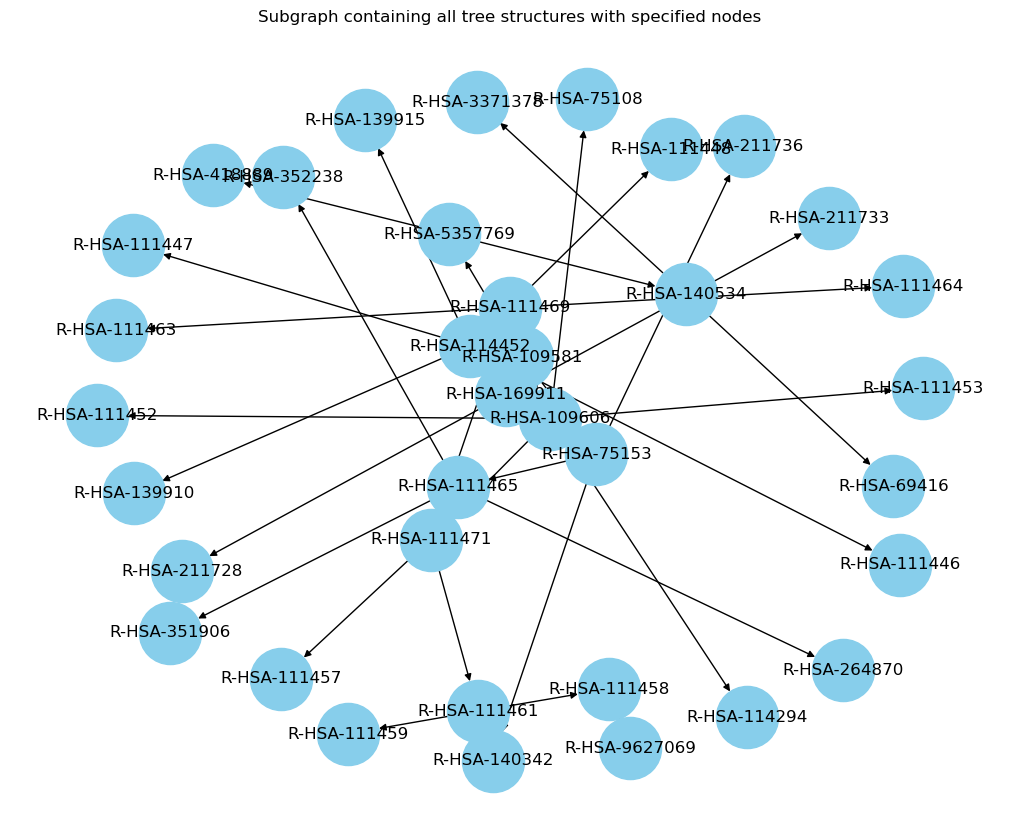

In [14]:
# 子通路 R-HSA-109581 树状结构
specified_nodes = ['R-HSA-109581']
subgraph = nx.DiGraph()

for node in specified_nodes:
    bfs_tree = nx.bfs_tree(net, node)
    subgraph.add_edges_from(bfs_tree.edges())

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos=pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=12)
plt.title('Subgraph containing all tree structures with specified nodes')
plt.show()

选择度大于5的节点绘图

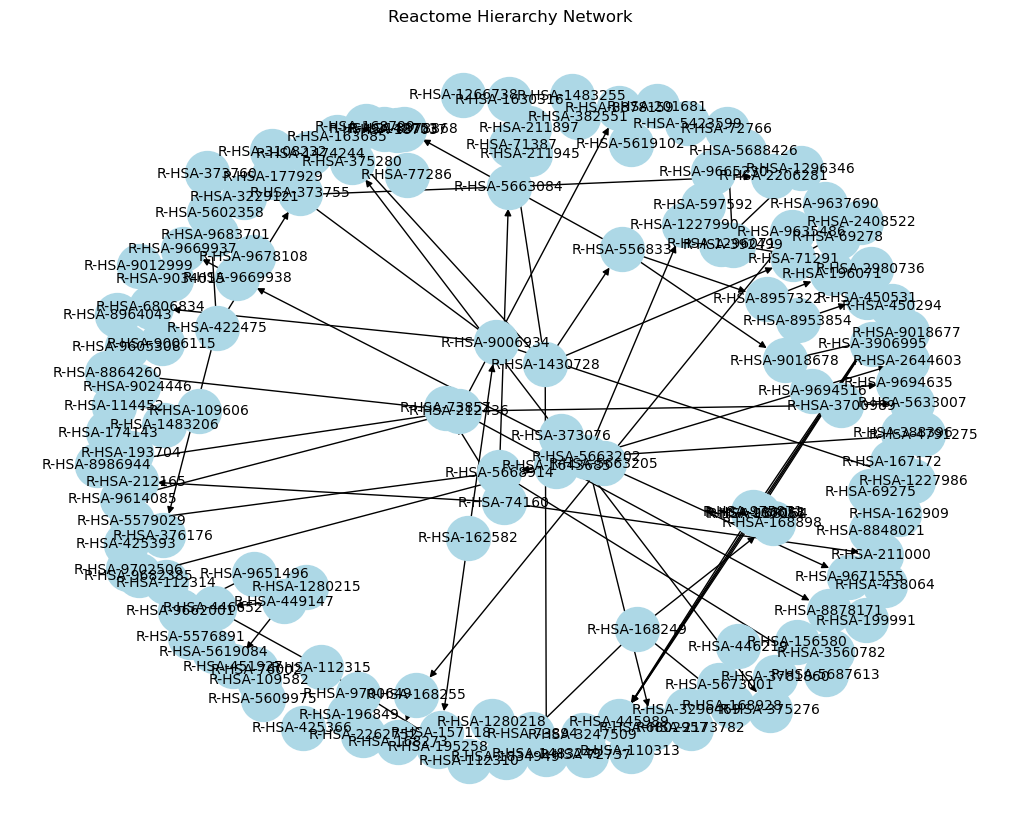

In [15]:
selected_nodes = [node for node, degree in net.degree() if degree > 5]
subgraph = net.subgraph(selected_nodes)
pos = nx.random_layout(subgraph, seed=42)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
nx.draw(subgraph, with_labels=True, node_size=1000, node_color='lightblue', font_size=10)
plt.title('Reactome Hierarchy Network')
plt.show()

添加 root 节点

In [16]:
# add root node
roots = [n for n, d in net.in_degree() if d == 0] # for the nodes whose in-degree is 0
roots

['R-HSA-109582',
 'R-HSA-112316',
 'R-HSA-1266738',
 'R-HSA-1430728',
 'R-HSA-1474165',
 'R-HSA-1474244',
 'R-HSA-1500931',
 'R-HSA-162582',
 'R-HSA-1640170',
 'R-HSA-1643685',
 'R-HSA-168256',
 'R-HSA-1852241',
 'R-HSA-382551',
 'R-HSA-392499',
 'R-HSA-397014',
 'R-HSA-400253',
 'R-HSA-4839726',
 'R-HSA-5357801',
 'R-HSA-5653656',
 'R-HSA-69306',
 'R-HSA-73894',
 'R-HSA-74160',
 'R-HSA-8953854',
 'R-HSA-8953897',
 'R-HSA-8963743',
 'R-HSA-9609507',
 'R-HSA-9612973',
 'R-HSA-9709957']

In [17]:
root_node = 'root'
edges = [(root_node, n) for n in roots]
edges

[('root', 'R-HSA-109582'),
 ('root', 'R-HSA-112316'),
 ('root', 'R-HSA-1266738'),
 ('root', 'R-HSA-1430728'),
 ('root', 'R-HSA-1474165'),
 ('root', 'R-HSA-1474244'),
 ('root', 'R-HSA-1500931'),
 ('root', 'R-HSA-162582'),
 ('root', 'R-HSA-1640170'),
 ('root', 'R-HSA-1643685'),
 ('root', 'R-HSA-168256'),
 ('root', 'R-HSA-1852241'),
 ('root', 'R-HSA-382551'),
 ('root', 'R-HSA-392499'),
 ('root', 'R-HSA-397014'),
 ('root', 'R-HSA-400253'),
 ('root', 'R-HSA-4839726'),
 ('root', 'R-HSA-5357801'),
 ('root', 'R-HSA-5653656'),
 ('root', 'R-HSA-69306'),
 ('root', 'R-HSA-73894'),
 ('root', 'R-HSA-74160'),
 ('root', 'R-HSA-8953854'),
 ('root', 'R-HSA-8953897'),
 ('root', 'R-HSA-8963743'),
 ('root', 'R-HSA-9609507'),
 ('root', 'R-HSA-9612973'),
 ('root', 'R-HSA-9709957')]

In [18]:
net.add_edges_from(edges)

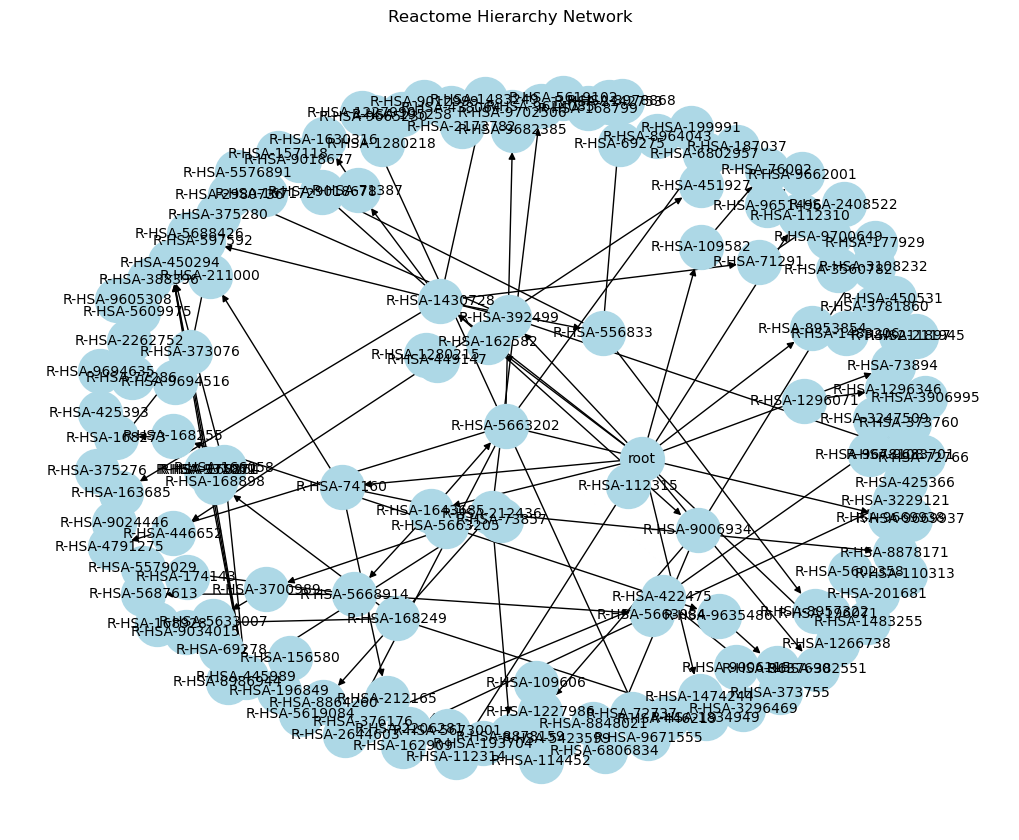

In [19]:
selected_nodes = [node for node, degree in net.degree() if degree > 5]
subgraph = net.subgraph(selected_nodes)
pos = nx.random_layout(subgraph, seed=42)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
nx.draw(subgraph, with_labels=True, node_size=1000, node_color='lightblue', font_size=10)
plt.title('Reactome Hierarchy Network')
plt.show()

网络基本信息

In [20]:
print(f'Number of nodes: {nx.number_of_nodes(net)}')
print(f'Number of edges: {nx.number_of_edges(net)}')
print(f'Average node degree: {nx.number_of_edges(net) / nx.number_of_nodes(net):.2f}')
print(f'Is directed: {nx.is_directed(net)}')

Number of nodes: 2547
Number of edges: 2593
Average node degree: 1.02
Is directed: True


In [21]:
print(net)

DiGraph named 'reactome' with 2547 nodes and 2593 edges


### ReactomeNetwork 类

In [22]:
'''
    向图 G 中添加从节点 node 开始的多级边（参数 n_levels 指定要添加的边的级别数量）：
        - 创建一个空列表 edges，用于存储要添加到图中的边
        - 使用循环迭代 n_levels 次，依次创建从 node 到 node_copy1、node_copy2 等的边
        - 每次迭代，根据当前级别 l 构建目标节点 target，并创建一条从当前节点 source 到目标节点 target 的边，并将其添加到 edges 列表中
        - 将 target 设置为下一次迭代的 source，以便在下一级别中使用
        - 使用 add_edges_from 方法将 edges 列表中的所有边添加到图 G 中
        - 返回更新后的图 G
'''
def add_edges(G, node, n_levels):
    edges = []
    source = node
    for l in range(n_levels):
        target = node + '_copy' + str(l + 1)
        edge = (source, target)
        source = target
        edges.append(edge)

    G.add_edges_from(edges)
    return G

'''
    完善一个给定的网络图 G，以确保从根节点到终端节点的距离至少为 n_levels：
        - 使用 nx.ego_graph(G, 'root', radius=n_leveles) 从图 G 中获取以根节点 'root' 为中心、半径为 n_leveles 的子图 sub_graph
        - 找到子图中的所有终端节点（即出度为0的节点），存储在列表 terminal_nodes 中
        - 对于每个终端节点 node:
            - 计算从根节点到终端节点的距离 distance，使用 nx.shortest_path(sub_graph, source='root', target=node) 计算最短路径的长度
            - 如果距离小于或等于 n_levels，则需要补充边，以确保距离达到 n_levels
            - 计算需要添加的边的数量 diff，即 n_levels - distance + 1
            - 调用 add_edges 函数将 diff 数量的边从终端节点添加到其相应的副本节点，以确保距离达到 n_levels
        - 返回更新后的子图 sub_graph
'''
def complete_network(G, n_leveles=4):
    sub_graph = nx.ego_graph(G, 'root', radius=n_leveles)
    terminal_nodes = [n for n, d in sub_graph.out_degree() if d == 0]
    # distances = [len(nx.shortest_path(G, source='root', target=node)) for node in terminal_nodes]
    for node in terminal_nodes:
        # distance from the root nodes to the terminal (final) nodes
        distance = len(nx.shortest_path(sub_graph, source='root', target=node))
        if distance <= n_leveles:
            # suppose a terminal node named 'node_t', if its distance from the root node is smaller 
            # than n_levels, we will create a copy named 'node_t_copy' and add an edge 'node_t' -> 'node_t_copy'
            diff = n_leveles - distance + 1
            sub_graph = add_edges(sub_graph, node, diff)

    return sub_graph


'''
    获取在给定距离内的所有节点（NetworkX 中的 ego_graph 函数来获取指定节点周围的子图，并根据给定的距离过滤节点）：
        - net 是一个 NetworkX 图对象
        - distance 是一个整数，表示要获取节点的距离
        - 函数首先使用 ego_graph 函数获取以根节点（这里是 'root'）为中心、指定半径为 distance 的子图
        - 如果 distance 大于等于 1，函数会删除那些距离小于给定距离的节点。这是通过计算距离为 distance - 1 的子图并将其从节点集合中删除来完成的
        - 函数返回一个列表，其中包含在给定距离内的所有节点
'''
def get_nodes_at_level(net, distance):
    # get all nodes within distance around the query node
    nodes = set(nx.ego_graph(net, 'root', radius=distance))

    # remove nodes that are not **at** the specified distance but closer
    if distance >= 1.:
        # remove the nodes whose distance is smaller than the given distance
        nodes -= set(nx.ego_graph(net, 'root', radius=distance - 1))

    return list(nodes)


'''
    获取网络图中与给定节点在特定距离内的所有节点：
        - 使用 nx.ego_graph(net, 'root', radius=distance) 获取以根节点 'root' 为中心、半径为 distance 的子图中的所有节点，并将其存储在集合 nodes 中
        - 如果指定的距离 distance 大于等于1，则需要移除那些距离小于给定距离的节点，以确保返回的节点是在指定距离上的节点
        - 返回存储节点的列表 nodes
'''
def get_layers_from_net(net, n_levels):
    layers = []
    for i in range(n_levels):
        nodes = get_nodes_at_level(net, i)
        dict = {}
        for n in nodes:
            n_name = re.sub('_copy.*', '', n) # remove the _copy from its original names
            next = net.successors(n)
            dict[n_name] = [re.sub('_copy.*', '', nex) for nex in next]
        layers.append(dict)
    return layers

In [23]:
class ReactomeNetwork():
    def __init__(self, data_dir):
        self.reactome = Reactome(data_dir)  # low level access to reactome pathways and genes
        self.netx = self.get_reactome_networkx()

    '''
        获取网络中的末端节点，即出度为0的节点
    '''
    def get_terminals(self):
        terminal_nodes = [n for n, d in self.netx.out_degree() if d == 0]
        return terminal_nodes


    '''
        获取网络中的根节点，即距离根节点为1的节点
    '''
    def get_roots(self):
        roots = get_nodes_at_level(self.netx, distance=1)
        return roots


    '''
       获取 Reactome 数据库的网络表示：
            - 如果已经创建了网络，就直接返回已经创建的网络对象
            - 否则，从 Reactome 数据库的层次结构中获取包含人类路径信息的子层次结构
                - 从 Reactome 数据库中加载层次结构数据
                - 从加载的数据中筛选出包含人类路径信息的子层次结构。这些信息通常以人类（Homo sapiens）基因的标识符开头（如"HSA"）
            - 使用 NetworkX 创建有向图
            - 添加根节点到图中
                - 通过检查每个节点的入度（in-degree），找到没有父节点的节点，即根节点的直接子节点
                - 创建一个名为 "root" 的虚拟节点，表示图的根节点
                - 将根节点与找到的直接子节点之间建立边
            - 返回创建的网络对象
    '''
    # get a DiGraph representation of the Reactome hierarchy
    def get_reactome_networkx(self):
        if hasattr(self, 'netx'):
            # already created the network
            return self.netx
        hierarchy = self.reactome.hierarchy
        # filter hierarchy to have human pathways only
        human_hierarchy = hierarchy[hierarchy['child'].str.contains('HSA')]
        net = nx.from_pandas_edgelist(human_hierarchy, 'child', 'parent', create_using=nx.DiGraph())
        net.name = 'reactome'

        # add root node
        roots = [n for n, d in net.in_degree() if d == 0] # for the nodes whose in-degree is 0
        root_node = 'root'
        edges = [(root_node, n) for n in roots]
        net.add_edges_from(edges)

        return net


    '''
       获取网络的信息，包括节点数量、边数量等
    '''
    def print_network_info(self):
        print(f'Number of nodes: {nx.number_of_nodes(self.netx)}')
        print(f'Number of edges: {nx.number_of_edges(self.netx)}')
        print(f'Average node degree: {nx.number_of_edges(self.netx) / nx.number_of_nodes(self.netx):.2f}')
        print(f'Is directed: {nx.is_directed(self.netx)}')


    '''
       获取网络的树形结构，通过对网络进行广度优先搜索（bfs）来构建树形结构
    '''
    def get_tree(self):
        # convert to tree
        G = nx.bfs_tree(self.netx, 'root')
        return G


    '''
       获取完整的网络，即在网络中添加了多余的节点和边以达到指定的层次数
    '''
    def get_completed_network(self, n_levels):
        G = complete_network(self.netx, n_leveles=n_levels)
        return G


    '''
       获取完整的树形结构，即在树形结构中添加了多余的节点和边以达到指定的层次数
    '''
    def get_completed_tree(self, n_levels):
        G = self.get_tree()
        G = complete_network(G, n_leveles=n_levels)
        return G


    '''
       获取网络的各个层次：
        - 如果direction为 'root_to_leaf'，则从根节点开始获取网络的层次结构，并使用函数 get_layers_from_net 提取每一层的信息。
            返回的 layers 是一个列表，其中每个元素是一个字典，表示一个层次，字典的键是节点名称，值是该节点的后继节点集合
        - 如果direction不是 'root_to_leaf'，则默认从根节点到叶节点获取完整的网络，然后从中提取最后 n_levels 层的信息。这是因为整个网络中的路径都是从根节点开始到叶节点结束的
        - 获取最后一层（基因级别）的信息：
            - 查找网络中的终端节点，即出度为 0 的节点，这些节点代表了最终的途径
            - 根据这些途径的名称从 Reactome 数据库中获取与之关联的基因
            - 将这些基因添加到字典中，并将该字典添加到 layers 列表中
    '''
    def get_layers(self, n_levels, direction='root_to_leaf'):
        if direction == 'root_to_leaf':
            '''
                net (DiGraph): root -> pathway, no genes
                layers (list): each element is a dict, denote one layer, 
                               whose key is the node name and the values are its successors
            '''
            print('get layers from root to leaf')
            net = self.get_completed_network(n_levels)
            layers = get_layers_from_net(net, n_levels)
        else:
            net = self.get_completed_network(5)
            layers = get_layers_from_net(net, 5)
            layers = layers[5 - n_levels:5]

        # get the last layer (genes level)
        terminal_nodes = [n for n, d in net.out_degree() if d == 0]  # set of terminal pathways
        # we need to find genes belonging to these pathways
        genes_df = self.reactome.pathway_genes

        # There are no genes in previous layers. Add the genes that directly link to the pathways
        dict = {}
        missing_pathways = []
        for p in terminal_nodes:
            pathway_name = re.sub('_copy.*', '', p)
            genes = genes_df[genes_df['group'] == pathway_name]['gene'].unique()
            if len(genes) == 0:
                missing_pathways.append(pathway_name)
            dict[pathway_name] = genes
        layers.append(dict)

        return layers

In [24]:
reactome_network = ReactomeNetwork(data_dir=data_dir)

In [25]:
reactome_network.print_network_info()

Number of nodes: 2547
Number of edges: 2593
Average node degree: 1.02
Is directed: True


In [26]:
print(len(reactome_network.get_terminals()))
reactome_network.get_terminals()

1793


['R-HSA-75205',
 'R-HSA-75892',
 'R-HSA-111452',
 'R-HSA-111453',
 'R-HSA-114294',
 'R-HSA-75108',
 'R-HSA-165160',
 'R-HSA-165158',
 'R-HSA-110312',
 'R-HSA-110320',
 'R-HSA-5655862',
 'R-HSA-5656121',
 'R-HSA-5656169',
 'R-HSA-110362',
 'R-HSA-5651801',
 'R-HSA-73930',
 'R-HSA-9627069',
 'R-HSA-111459',
 'R-HSA-264870',
 'R-HSA-351906',
 'R-HSA-352238',
 'R-HSA-111463',
 'R-HSA-111464',
 'R-HSA-111457',
 'R-HSA-180024',
 'R-HSA-202040',
 'R-HSA-163615',
 'R-HSA-111932',
 'R-HSA-111957',
 'R-HSA-111995',
 'R-HSA-170660',
 'R-HSA-170670',
 'R-HSA-112303',
 'R-HSA-181429',
 'R-HSA-181430',
 'R-HSA-210500',
 'R-HSA-212676',
 'R-HSA-264642',
 'R-HSA-210455',
 'R-HSA-112308',
 'R-HSA-112412',
 'R-HSA-110056',
 'R-HSA-112411',
 'R-HSA-113501',
 'R-HSA-113507',
 'R-HSA-111446',
 'R-HSA-111447',
 'R-HSA-111448',
 'R-HSA-139910',
 'R-HSA-139915',
 'R-HSA-426048',
 'R-HSA-1169091',
 'R-HSA-1169092',
 'R-HSA-2025928',
 'R-HSA-1169408',
 'R-HSA-8983711',
 'R-HSA-1433617',
 'R-HSA-1300642',
 'R-HS

Pathway 'R-HSA-110362' 在 terminal 节点列表中
<html>
    <img src="./Figure_1c.png", width=591, heigth=280>
    <figcaption>Figure 1c from BioXNet</figcaption>
</html>

In [27]:
'R-HSA-110362' in reactome_network.get_terminals()

True

In [28]:
print(len(reactome_network.get_roots()))
reactome_network.get_roots()

28


['R-HSA-382551',
 'R-HSA-397014',
 'R-HSA-73894',
 'R-HSA-74160',
 'R-HSA-1852241',
 'R-HSA-5357801',
 'R-HSA-9612973',
 'R-HSA-109582',
 'R-HSA-392499',
 'R-HSA-9609507',
 'R-HSA-1266738',
 'R-HSA-1474244',
 'R-HSA-8953854',
 'R-HSA-8953897',
 'R-HSA-1640170',
 'R-HSA-1643685',
 'R-HSA-400253',
 'R-HSA-1500931',
 'R-HSA-162582',
 'R-HSA-5653656',
 'R-HSA-1474165',
 'R-HSA-9709957',
 'R-HSA-69306',
 'R-HSA-168256',
 'R-HSA-8963743',
 'R-HSA-112316',
 'R-HSA-4839726',
 'R-HSA-1430728']

获取树形结构

In [29]:
net_tree= reactome_network.get_tree()

In [30]:
print(net_tree)

DiGraph with 2547 nodes and 2546 edges


获取以根节点 'root' 为中心、半径为 n_levels=4 的子图 sub_graph

In [31]:
net_completed= reactome_network.get_completed_network(n_levels=4)

In [32]:
print(net_completed)

DiGraph named 'reactome' with 1797 nodes and 1809 edges


获取网络的各个层次
- 层次是指以 'root' 节点为中心，半径为 0 到 n_levels 的子图
- 每个层次是一个元素，该元素以字典形式储存，以某个节点为键，以该节点的后继节点集合为值）

In [33]:
layers = []

In [34]:
# 以 n_levels=0 或 1 为例
nodes = get_nodes_at_level(net, 0)
nodes

['root']

In [35]:
dict = {}
n_name = re.sub('_copy.*', '', 'root') # remove the _copy from its original names
n_name

'root'

In [36]:
next = net.successors('root')
dict[n_name] = [re.sub('_copy.*', '', nex) for nex in next]
dict

{'root': ['R-HSA-109582',
  'R-HSA-112316',
  'R-HSA-1266738',
  'R-HSA-1430728',
  'R-HSA-1474165',
  'R-HSA-1474244',
  'R-HSA-1500931',
  'R-HSA-162582',
  'R-HSA-1640170',
  'R-HSA-1643685',
  'R-HSA-168256',
  'R-HSA-1852241',
  'R-HSA-382551',
  'R-HSA-392499',
  'R-HSA-397014',
  'R-HSA-400253',
  'R-HSA-4839726',
  'R-HSA-5357801',
  'R-HSA-5653656',
  'R-HSA-69306',
  'R-HSA-73894',
  'R-HSA-74160',
  'R-HSA-8953854',
  'R-HSA-8953897',
  'R-HSA-8963743',
  'R-HSA-9609507',
  'R-HSA-9612973',
  'R-HSA-9709957']}

In [37]:
layers.append(dict)
layers[0]

{'root': ['R-HSA-109582',
  'R-HSA-112316',
  'R-HSA-1266738',
  'R-HSA-1430728',
  'R-HSA-1474165',
  'R-HSA-1474244',
  'R-HSA-1500931',
  'R-HSA-162582',
  'R-HSA-1640170',
  'R-HSA-1643685',
  'R-HSA-168256',
  'R-HSA-1852241',
  'R-HSA-382551',
  'R-HSA-392499',
  'R-HSA-397014',
  'R-HSA-400253',
  'R-HSA-4839726',
  'R-HSA-5357801',
  'R-HSA-5653656',
  'R-HSA-69306',
  'R-HSA-73894',
  'R-HSA-74160',
  'R-HSA-8953854',
  'R-HSA-8953897',
  'R-HSA-8963743',
  'R-HSA-9609507',
  'R-HSA-9612973',
  'R-HSA-9709957']}

In [38]:
nodes = get_nodes_at_level(net, 1)
print(len(nodes))
nodes

28


['R-HSA-382551',
 'R-HSA-397014',
 'R-HSA-73894',
 'R-HSA-74160',
 'R-HSA-1852241',
 'R-HSA-5357801',
 'R-HSA-9612973',
 'R-HSA-109582',
 'R-HSA-392499',
 'R-HSA-9609507',
 'R-HSA-1266738',
 'R-HSA-1474244',
 'R-HSA-8953854',
 'R-HSA-8953897',
 'R-HSA-1640170',
 'R-HSA-1643685',
 'R-HSA-400253',
 'R-HSA-1500931',
 'R-HSA-162582',
 'R-HSA-5653656',
 'R-HSA-1474165',
 'R-HSA-9709957',
 'R-HSA-69306',
 'R-HSA-168256',
 'R-HSA-8963743',
 'R-HSA-112316',
 'R-HSA-4839726',
 'R-HSA-1430728']

In [39]:
dict = {}
for n in nodes:
    n_name = re.sub('_copy.*', '', n) # remove the _copy from its original names
    next = net.successors(n)
    dict[n_name] = [re.sub('_copy.*', '', nex) for nex in next]
    if(n=='R-HSA-9709957'): # Take an example
        print(dict)
layers.append(dict)

{'R-HSA-382551': ['R-HSA-1480926', 'R-HSA-174824', 'R-HSA-382556', 'R-HSA-425407', 'R-HSA-445717', 'R-HSA-5223345', 'R-HSA-8949215', 'R-HSA-8981607', 'R-HSA-917937', 'R-HSA-983712'], 'R-HSA-397014': ['R-HSA-390522', 'R-HSA-445355', 'R-HSA-5576891'], 'R-HSA-73894': ['R-HSA-5358508', 'R-HSA-5693532', 'R-HSA-5696398', 'R-HSA-6783310', 'R-HSA-73884', 'R-HSA-73893', 'R-HSA-73942'], 'R-HSA-74160': ['R-HSA-211000', 'R-HSA-212165', 'R-HSA-73857', 'R-HSA-73864', 'R-HSA-74158', 'R-HSA-75944'], 'R-HSA-1852241': ['R-HSA-1592230', 'R-HSA-5617833'], 'R-HSA-5357801': ['R-HSA-109581', 'R-HSA-5218859'], 'R-HSA-9612973': ['R-HSA-1632852', 'R-HSA-9613829', 'R-HSA-9615710'], 'R-HSA-109582': ['R-HSA-140877', 'R-HSA-202733', 'R-HSA-418346', 'R-HSA-75205', 'R-HSA-75892', 'R-HSA-76002', 'R-HSA-983231'], 'R-HSA-392499': ['R-HSA-2980736', 'R-HSA-381426', 'R-HSA-391251', 'R-HSA-5676934', 'R-HSA-5683826', 'R-HSA-597592', 'R-HSA-72766', 'R-HSA-977225'], 'R-HSA-9609507': ['R-HSA-1268020', 'R-HSA-9033241', 'R-HSA-96

In [40]:
print(len(layers[1])) # 共有 28 个与 'root' 节点的距离为 1 的节点，对应 28 个键值对
layers[1]

28


{'R-HSA-382551': ['R-HSA-1480926',
  'R-HSA-174824',
  'R-HSA-382556',
  'R-HSA-425407',
  'R-HSA-445717',
  'R-HSA-5223345',
  'R-HSA-8949215',
  'R-HSA-8981607',
  'R-HSA-917937',
  'R-HSA-983712'],
 'R-HSA-397014': ['R-HSA-390522', 'R-HSA-445355', 'R-HSA-5576891'],
 'R-HSA-73894': ['R-HSA-5358508',
  'R-HSA-5693532',
  'R-HSA-5696398',
  'R-HSA-6783310',
  'R-HSA-73884',
  'R-HSA-73893',
  'R-HSA-73942'],
 'R-HSA-74160': ['R-HSA-211000',
  'R-HSA-212165',
  'R-HSA-73857',
  'R-HSA-73864',
  'R-HSA-74158',
  'R-HSA-75944'],
 'R-HSA-1852241': ['R-HSA-1592230', 'R-HSA-5617833'],
 'R-HSA-5357801': ['R-HSA-109581', 'R-HSA-5218859'],
 'R-HSA-9612973': ['R-HSA-1632852', 'R-HSA-9613829', 'R-HSA-9615710'],
 'R-HSA-109582': ['R-HSA-140877',
  'R-HSA-202733',
  'R-HSA-418346',
  'R-HSA-75205',
  'R-HSA-75892',
  'R-HSA-76002',
  'R-HSA-983231'],
 'R-HSA-392499': ['R-HSA-2980736',
  'R-HSA-381426',
  'R-HSA-391251',
  'R-HSA-5676934',
  'R-HSA-5683826',
  'R-HSA-597592',
  'R-HSA-72766',
  'R-H

In [41]:
layers = get_layers_from_net(net_completed, n_levels=4)
print(len(layers))

4


In [42]:
terminal_nodes = [n for n, d in net_completed.out_degree() if d == 0]  # set of terminal pathways
terminal_nodes

['R-HSA-111452',
 'R-HSA-111453',
 'R-HSA-111471',
 'R-HSA-114294',
 'R-HSA-114452',
 'R-HSA-75108',
 'R-HSA-110312',
 'R-HSA-110320',
 'R-HSA-5655862',
 'R-HSA-5656121',
 'R-HSA-5656169',
 'R-HSA-110373',
 'R-HSA-110381',
 'R-HSA-111465',
 'R-HSA-111997',
 'R-HSA-181429',
 'R-HSA-181430',
 'R-HSA-210500',
 'R-HSA-212676',
 'R-HSA-264642',
 'R-HSA-888590',
 'R-HSA-379401',
 'R-HSA-380615',
 'R-HSA-210455',
 'R-HSA-181431',
 'R-HSA-399721',
 'R-HSA-442755',
 'R-HSA-451326',
 'R-HSA-977443',
 'R-HSA-112409',
 'R-HSA-426048',
 'R-HSA-1168372',
 'R-HSA-1169410',
 'R-HSA-1222499',
 'R-HSA-8941413',
 'R-HSA-5655253',
 'R-HSA-5655291',
 'R-HSA-5655302',
 'R-HSA-5655332',
 'R-HSA-1250196',
 'R-HSA-1251932',
 'R-HSA-1306955',
 'R-HSA-1963640',
 'R-HSA-1963642',
 'R-HSA-6785631',
 'R-HSA-8847993',
 'R-HSA-8863795',
 'R-HSA-9652282',
 'R-HSA-9634285',
 'R-HSA-9664565',
 'R-HSA-9665230',
 'R-HSA-9665348',
 'R-HSA-9665686',
 'R-HSA-9665737',
 'R-HSA-1234158',
 'R-HSA-1234176',
 'R-HSA-1250342',
 'R

In [43]:
genes_df= pathway_genes
genes_df

,group,gene
0,R-HSA-164843,HMGA1
1,R-HSA-164843,LIG4
2,R-HSA-164843,PSIP1
3,R-HSA-164843,XRCC4
4,R-HSA-164843,XRCC5
...,...,...
118300,R-HSA-192905,NP
118301,R-HSA-192905,NS
118302,R-HSA-192905,PA
118303,R-HSA-192905,PB1


In [44]:
dict = {}
missing_pathways = []
pathway_name = re.sub('_copy.*', '', 'R-HSA-450604_copy1')
pathway_name

'R-HSA-450604'

In [45]:
genes = genes_df[genes_df['group'] == pathway_name]['gene'].unique()
genes

array(['DCP2', 'DIS3', 'EXOSC1', 'EXOSC2', 'EXOSC3', 'EXOSC4', 'EXOSC5',
       'EXOSC6', 'EXOSC7', 'EXOSC8', 'EXOSC9', 'KHSRP', 'MAPK11',
       'MAPK14', 'PARN', 'YWHAZ'], dtype=object)

In [46]:
if len(genes) == 0:
    missing_pathways.append(pathway_name)
missing_pathways

[]

In [47]:
dict[pathway_name] = genes
dict

{'R-HSA-450604': array(['DCP2', 'DIS3', 'EXOSC1', 'EXOSC2', 'EXOSC3', 'EXOSC4', 'EXOSC5',
        'EXOSC6', 'EXOSC7', 'EXOSC8', 'EXOSC9', 'KHSRP', 'MAPK11',
        'MAPK14', 'PARN', 'YWHAZ'], dtype=object)}

In [48]:
dict = {}
missing_pathways = []
for p in terminal_nodes:
    pathway_name = re.sub('_copy.*', '', p)
    genes = genes_df[genes_df['group'] == pathway_name]['gene'].unique()
    if len(genes) == 0:
        missing_pathways.append(pathway_name)
    dict[pathway_name] = genes
layers.append(dict)

In [49]:
print(len(layers))
layers[4]

5


{'R-HSA-111452': array(['BID'], dtype=object),
 'R-HSA-111453': array(['BBC3', 'BCL2', 'BCL2L1', 'BCL2L11', 'BID', 'BMF', 'PMAIP1',
        'STAT3'], dtype=object),
 'R-HSA-111471': array(['APIP', 'AVEN', 'BAK1', 'BAX', 'C1QBP', 'CARD8', 'CASP3', 'CASP7',
        'CASP9', 'CDKN2A', 'CYCS', 'DIABLO', 'GSDMD', 'GSDME', 'MAPK1',
        'MAPK3', 'SEPTIN4', 'UACA', 'XIAP'], dtype=object),
 'R-HSA-114294': array(['BID'], dtype=object),
 'R-HSA-114452': array(['AKT2', 'AKT3', 'BAD', 'BBC3', 'BCL2', 'BCL2L11', 'BID', 'BMF',
        'DYNLL1', 'DYNLL2', 'E2F1', 'MAPK8', 'PMAIP1', 'PPP1R13B',
        'PPP3CC', 'PPP3R1', 'SFN', 'TFDP1', 'TFDP2', 'TP53', 'TP53BP2',
        'TP63', 'TP73', 'YWHAB', 'YWHAE', 'YWHAG', 'YWHAH', 'YWHAQ',
        'YWHAZ'], dtype=object),
 'R-HSA-75108': array(['CASP8', 'GZMB', 'NMT1'], dtype=object),
 'R-HSA-110312': array(['PCNA', 'REV1', 'REV3L', 'RFC1', 'RFC2', 'RFC3', 'RFC4', 'RFC5',
        'RPA1', 'RPA2', 'RPA3', 'RPS27A', 'UBA52', 'UBB', 'UBC'],
       dtype=obje